### Labb 2 

- a) Börja med att ladda ned datasetet Dogs vs Cats från Kaggle. Extrahera den och lägg den i din labfolder,
glöm inte att lägga till den till .gitignore.

-----


## b)

 - Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.


In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os # Used for interacting with the operating system. Essential for file and directory operations.
import random
from PIL import Image # Part of the Pillow library, used for opening, manipulating, and saving many different image file formats.

In [2]:
# Set the directory path where the images are stored.
source_dir = "original_data/train/train"

# List all files in the specified directory and filter to include only '.jpg' files.
image_files = [f for f in os.listdir(source_dir) if f.endswith('.jpg')]

# Randomly select 10 images from the list of jpg files.
selected_images = random.sample(image_files, 10)

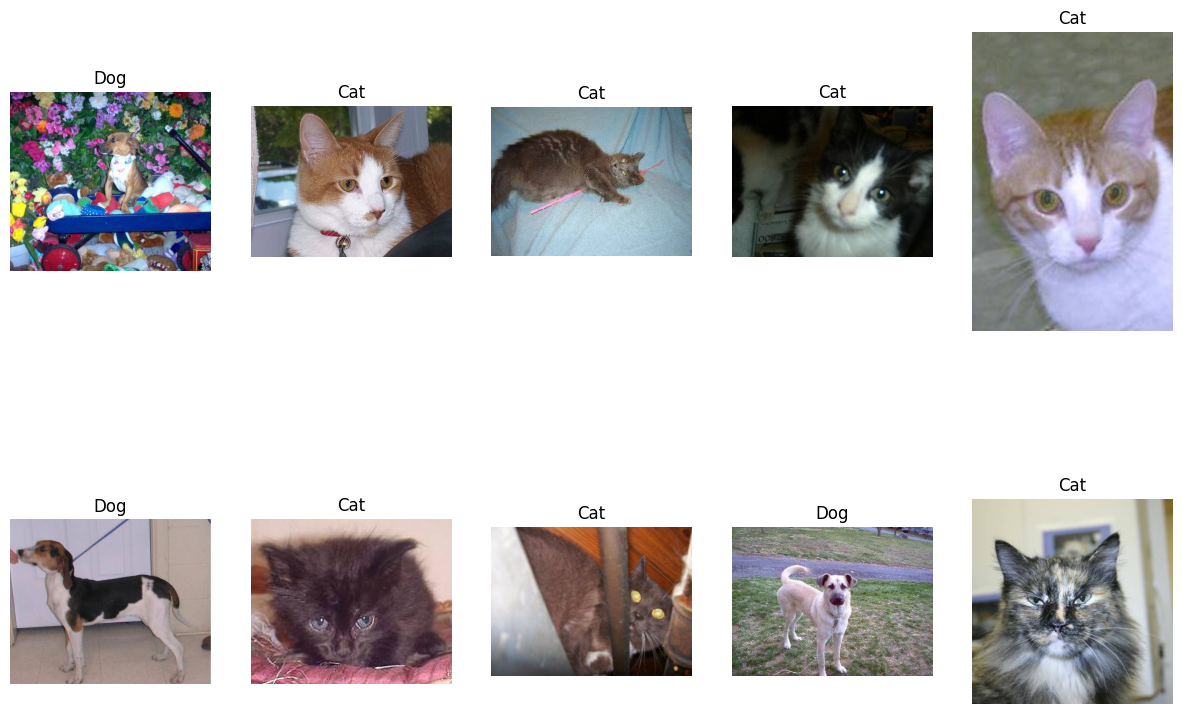

In [3]:
plt.figure(figsize=(15, 10))

# Loop through each selected image file.
for i, image_file in enumerate(selected_images):
    # Open the image file using the PIL library and join path components.
    img = Image.open(os.path.join(source_dir, image_file))
    
    # Determine the label ('Cat' or 'Dog') based on the presence of 'cat' in the file name.
    label = 'Cat' if 'cat' in image_file else 'Dog'
    
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img) # Display the image in the current subplot.
    plt.title(label) # Set the title of the subplot to the label of the image.
    plt.axis('off')

plt.show()

------

## c)

- Skapa folderstrukturen nedan med Python

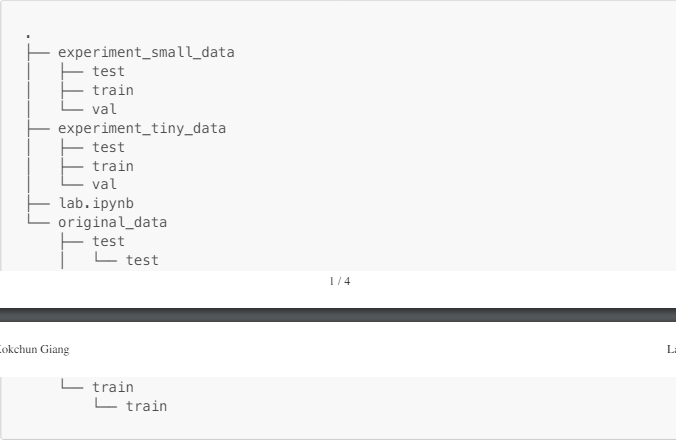     ---->      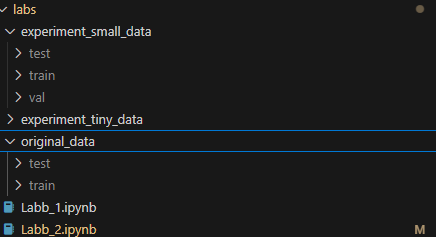
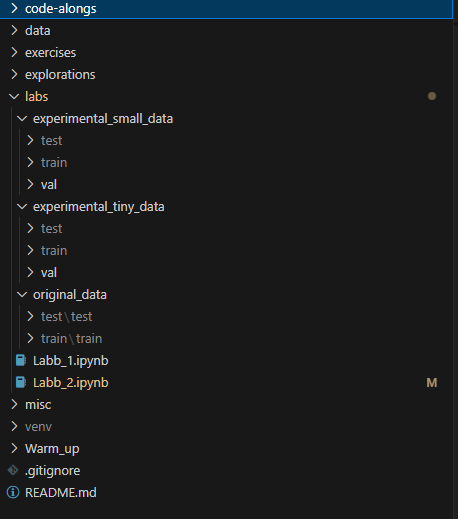

-----

### d)

- d) Nu ska du göra train|val|test split med följande splits:
    - experiment_small
    - train - 1600 (800 dogs, 800 cats)
    - val - 400 (200 dogs, 200 cats)
    - test - 500 (250 dogs, 250 cats)

Det är inte så farligt om det inte blir exakt balanserade dataset.
Det är viktigt att du samplar slumpmässigt utan replacement från originaldatasetet under respektive
experiment. Spara datan i deras respektive mappar. (**)


In [4]:
import shutil

base_dir = "experiment_small_data"
source_dir = "original_data/train/train"  

sets = ['train', 'val', 'test']

# Define number of pics for each category
split_counts = {
    'train': {'dogs': 800, 'cats': 800},
    'val': {'dogs': 200, 'cats': 200},
    'test': {'dogs': 250, 'cats': 250}
}

def check_if_distribution_needed():
    # Check if distributuion already has been done.
    for set in sets:
        path = os.path.join(base_dir, set)
        if sum(len(files) for _, _, files in os.walk(path)) != sum(split_counts[set].values()):
            return True
    return False

def distribute_files():
    if not check_if_distribution_needed():
        print("Fördelning har redan slutförts. Inga ytterligare åtgärder krävs.")
        return

    # shuffle all files for ranodomness
    files = {'dogs': [f for f in os.listdir(source_dir) if 'dog' in f], 'cats': [f for f in os.listdir(source_dir) if 'cat' in f]}
    for category in files:
        random.shuffle(files[category])

    # move files 
    for set in sets:
        for category in files:
            amount = split_counts[set][category]
            selected_files = files[category][:amount]
            files[category] = files[category][amount:]  

            for file in selected_files:
                shutil.move(os.path.join(source_dir, file), os.path.join(base_dir, set, file))

distribute_files()


Fördelning har redan slutförts. Inga ytterligare åtgärder krävs.


In [5]:
directories = ["experiment_small_data/train", "experiment_small_data/test", "experiment_small_data/val"]


def count_files(directory):
    dog_count = sum('dog' in f for f in os.listdir(directory))
    cat_count = sum('cat' in f for f in os.listdir(directory))
    return dog_count, cat_count


for directory in directories:
    dogs, cats = count_files(directory)
    print(f"{directory}:")
    print("Dogs:", dogs)
    print("Cats:", cats)



experiment_small_data/train:
Dogs: 800
Cats: 800
experiment_small_data/test:
Dogs: 250
Cats: 250
experiment_small_data/val:
Dogs: 200
Cats: 200


----------

### e) 
Läs in dataseten från experiment_small, experiment_tiny (BONUS) och plocka ut labelsvektorer, som
ska vara one-hot encoded med 0 och 1.
- plotta några bilder med deras respektive labels och kontrollera att det är korrekt.
- skapa lämplig plot för att kontrollera att dataseten är balanserade
- skapa lämplig plot för att kontrollera att dataseten är slumpade, dvs inte ex [0, 0, ... 0, 1, 1, ..., 1]




Funktion som laddar bilder från en mapp och extraherar deras labels.
- Blandar ordningen på filnamnen. Detta säkerställer att ordningen på filerna i mappen är slumpmässig innan bilderna laddas och etiketterna extraheras
- Loopar igenom filer i mapp (directory).
- Laddar varje bild och konverterar den till en numpy-array.
- Hämtar etiketten för varje bild baserat på filnamnet (om "dog" finns i filnamnet sätts etiketten till 0, annars sätts den till 1).
- Returnerar bilder och etiketter som numpy-arrays.

Etiketterna för bilderna i tränings-, validerings- och testmapparna konverteras till one-hot encoding-formatet.



In [6]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


def load_images_and_labels(directory):
    # Get a list of filenames in the directory
    file_names = os.listdir(directory)
    # Shuffle the list to randomize the order of files
    random.shuffle(file_names)
    
    # Using list comprehension to load images and create labels
    images = []
    labels = []
    for file in file_names:
        if os.path.isfile(os.path.join(directory, file)):
            try:
                img_path = os.path.join(directory, file)
                img = load_img(img_path)
                img_array = img_to_array(img) / 255.0  # Normalize the image
                images.append(img_array)
                labels.append(0 if 'dog' in file else 1)
            except Exception as e:
                print(f"Error loading image: {img_path}. {e}")

    return images, np.array(labels)

# Directory paths
train_dir = "experiment_small_data/train"
val_dir = "experiment_small_data/val"
test_dir = "experiment_small_data/test"

# Load images and labels from the directories
X_train, y_train = load_images_and_labels(train_dir)
X_val, y_val = load_images_and_labels(val_dir)
X_test, y_test = load_images_and_labels(test_dir)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)






plotta några bilder med deras respektive labels och kontrollera att det är korrekt
- ser korrekt ut

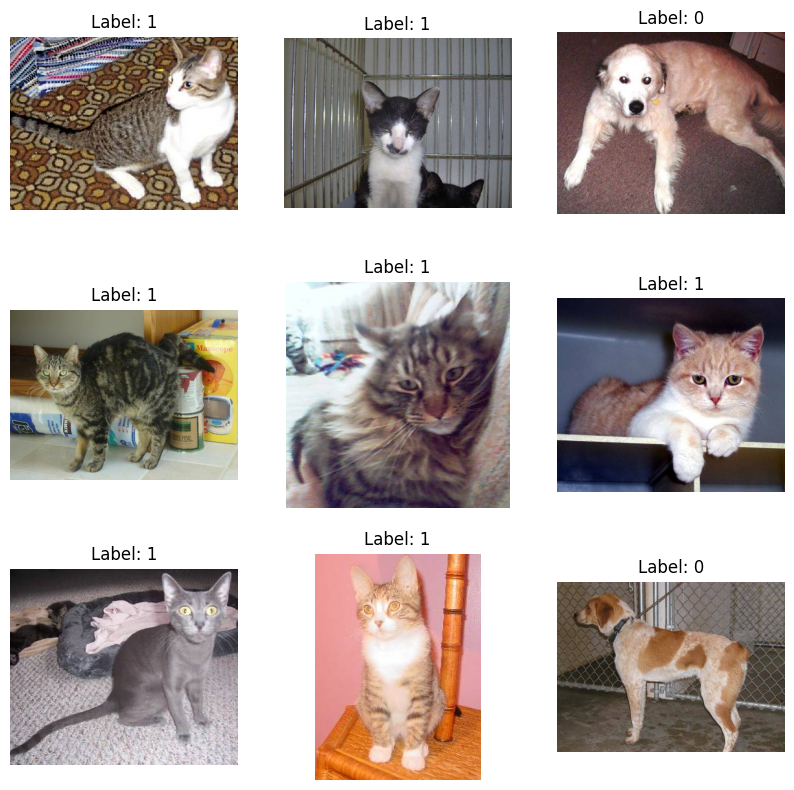

In [7]:
num_images = 9  
plt.figure(figsize=(10, 10))

# Pick random images from training folder
train_files = os.listdir(train_dir)
random_files = np.random.choice(train_files, size=num_images, replace=False)

for i, file in enumerate(random_files):
    img_path = os.path.join(train_dir, file)
    img = load_img(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    
    # get label 
    label_index = 0 if 'dog' in file.split('.')[0] else 1  # 0 for dog 1 for cat
    plt.title("Label: " + str(label_index))  
    plt.axis("off")

plt.show()

skapa lämplig plot för att kontrollera att dataseten är balanserade


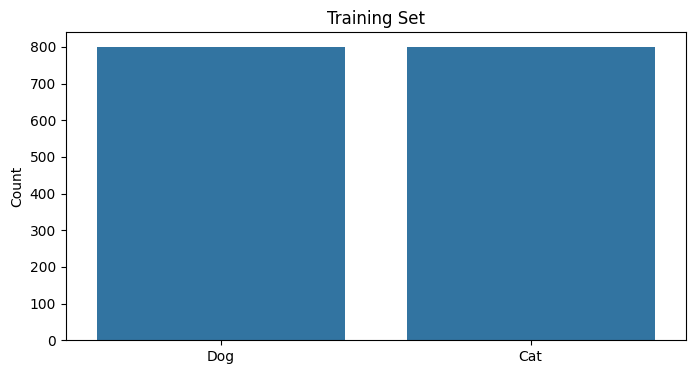

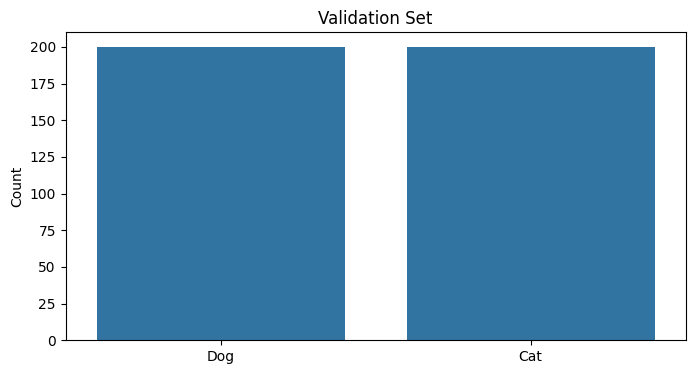

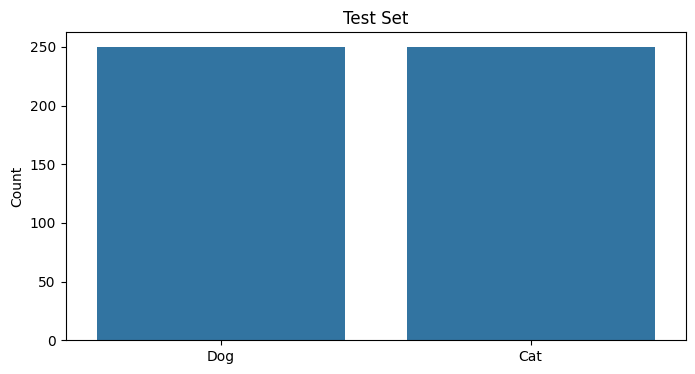

In [8]:
def plot_class_distribution(y_data, title):
    
    class_sums = np.sum(y_data, axis=0)
    classes = ['Dog', 'Cat']
    
    plt.figure(figsize=(8, 4))
    sns.barplot(x=classes, y=class_sums)
    plt.title(title)
    plt.ylabel('Count')
    plt.show()


plot_class_distribution(y_train, "Training Set")
plot_class_distribution(y_val, "Validation Set")
plot_class_distribution(y_test, "Test Set")




skapa lämplig plot för att kontrollera att dataseten är slumpade, dvs inte ex
[0, 0, ... 0, 1, 1, ..., 1]

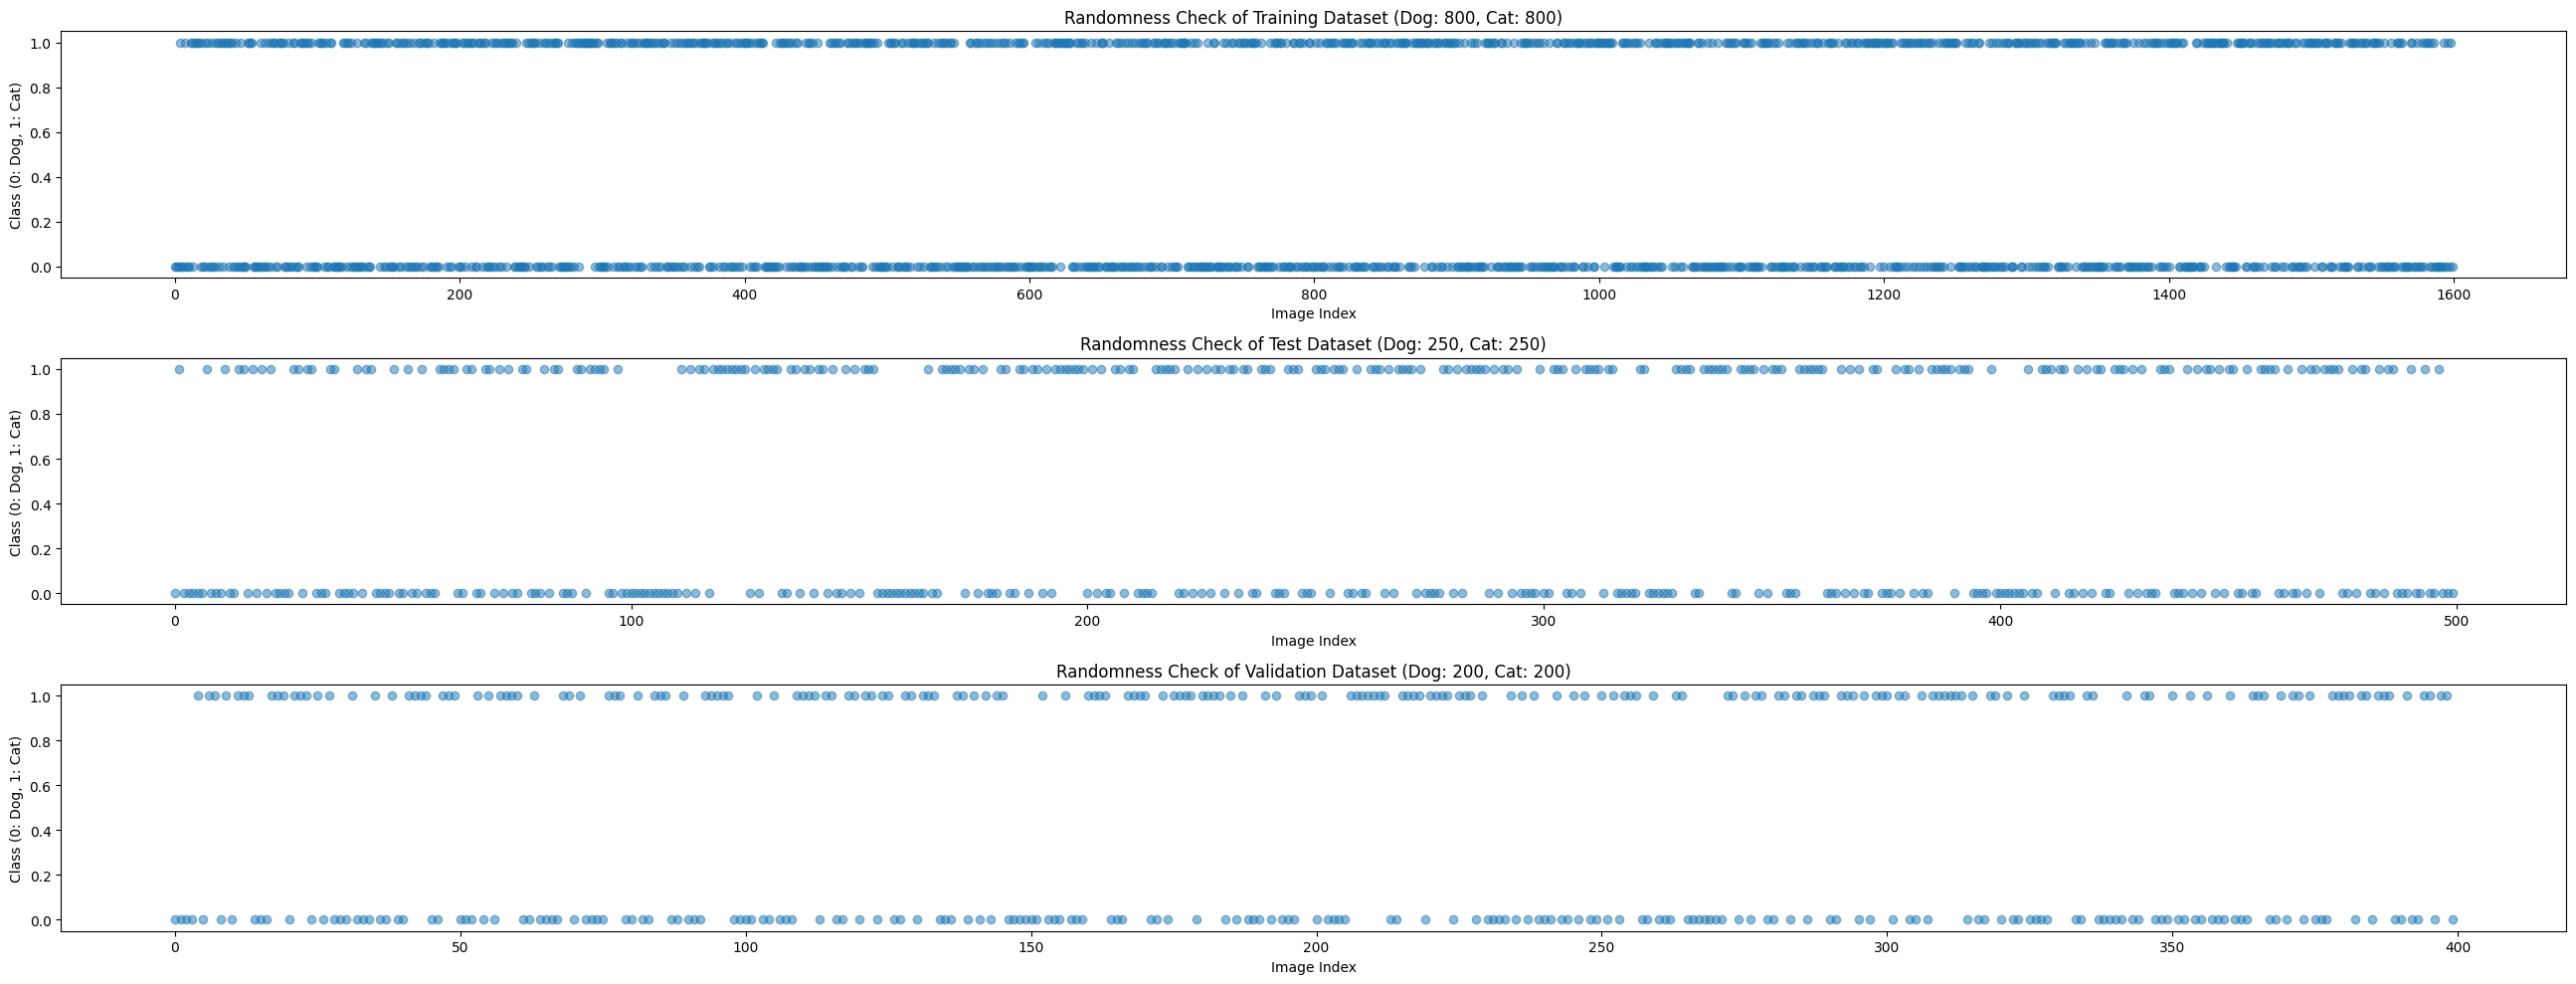

In [9]:
# Count the occurrences of each class in the training, test, and validation data
train_class_counts = np.bincount(y_train.argmax(axis=1))
test_class_counts = np.bincount(y_test.argmax(axis=1))
val_class_counts = np.bincount(y_val.argmax(axis=1))

# Create three line plots to show the distribution of classes in the training, test, and validation data
plt.figure(figsize=(26, 10))

# Training data
plt.subplot(3, 1, 1)
plt.plot(range(len(y_train)), y_train.argmax(axis=1), marker='o', linestyle='', alpha=0.5)
plt.title(f'Randomness Check of Training Dataset (Dog: {train_class_counts[0]}, Cat: {train_class_counts[1]})')
plt.xlabel('Image Index')
plt.ylabel('Class (0: Dog, 1: Cat)')

# Test data
plt.subplot(3, 1, 2)
plt.plot(range(len(y_test)), y_test.argmax(axis=1), marker='o', linestyle='', alpha=0.5)
plt.title(f'Randomness Check of Test Dataset (Dog: {test_class_counts[0]}, Cat: {test_class_counts[1]})')
plt.xlabel('Image Index')
plt.ylabel('Class (0: Dog, 1: Cat)')

# Validation data
plt.subplot(3, 1, 3)
plt.plot(range(len(y_val)), y_val.argmax(axis=1), marker='o', linestyle='', alpha=0.5)
plt.title(f'Randomness Check of Validation Dataset (Dog: {val_class_counts[0]}, Cat: {val_class_counts[1]})')
plt.xlabel('Image Index')
plt.ylabel('Class (0: Dog, 1: Cat)')

plt.tight_layout()
plt.show()





-----

### 1. Bildbehandling (*)

Uppgifterna nedan ska upprepas för respektive experimentdataset om du också väljer att arbeta med
tinydatasetet.
- a) Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot.
- b) Välj en lämplig bildstorlek att ändra samtliga bilder till. Gör en analys och fundera på om du behöver
slänga bilder. Hur kommer du fram till ditt val?
- c) Gör resize sådant att samtliga bilder är samma storlek och spara dem i numpy arrays med följande
struktur:
(samples, row, cols, color_channels)
Visualisera därefter ett par styckena bilder.
- d) Augmentera datan. Varför behövs dataaugmentering och hur beslutar du vilka parametrar du valt för
augmenteringen?

Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot.

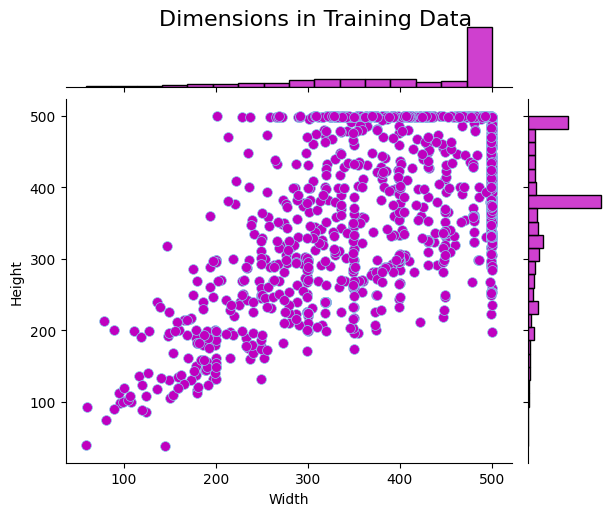

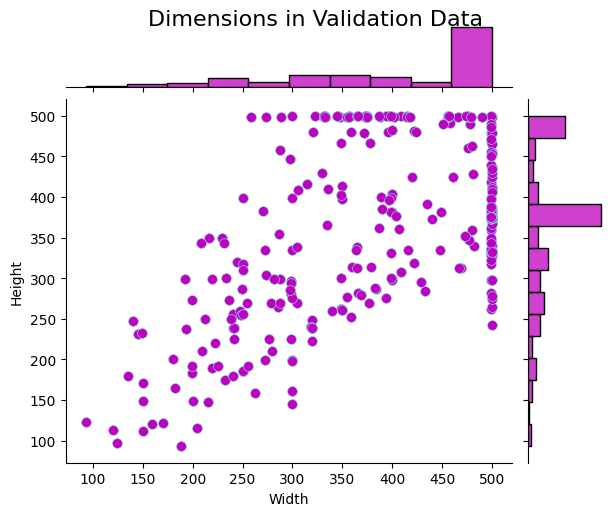

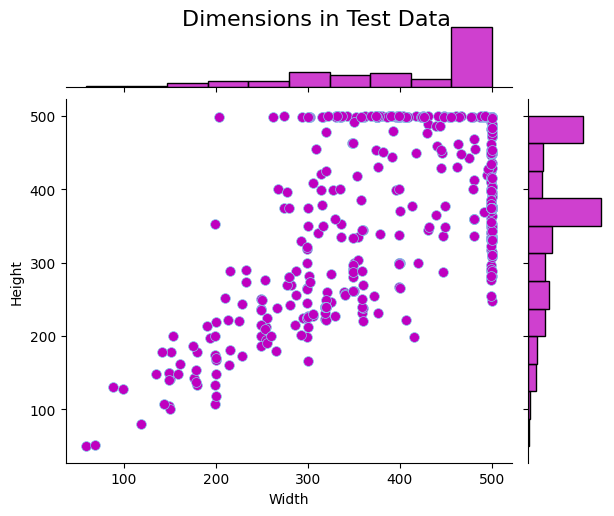

In [10]:
def plot_image_dimensions(X, title, plot_height=6):
    
    heights = [img.shape[0] for img in X]
    widths = [img.shape[1] for img in X]

    data = pd.DataFrame({'Height': heights, 'Width': widths})

    g = sns.jointplot(data=data, x='Width', y='Height', kind='scatter', color='m', s=50, edgecolor="skyblue", linewidth=0.5, height=plot_height)
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.95)  

    g.fig.set_figwidth(6)  
    g.fig.set_figheight(5)  

    plt.show()


plot_image_dimensions(X_train, 'Dimensions in Training Data', plot_height=8)
plot_image_dimensions(X_val, 'Dimensions in Validation Data', plot_height=8)
plot_image_dimensions(X_test, 'Dimensions in Test Data', plot_height=8)




Välj en lämplig bildstorlek att ändra samtliga bilder till. Gör en analys och fundera på om du behöver
slänga bilder. Hur kommer du fram till ditt val?

- Då det verkar som att de flesta eller iaf många bilder ligger i det högre spannet av 500 i antingen height eller width så kanske den storleken är för stor för modellen senare!?. Jag tänker att kanske runt 300x300 borde vara en okej storlek och då bör väl detaljerna bevaras utan att vara för stor så beräkningarna tar för lång tid.


Gör resize sådant att samtliga bilder är samma storlek och spara dem i numpy arrays med följande
struktur:
(samples, row, cols, color_channels)

Ändra Storlek på Bilderna till 300x300 och konverterar listan av bilder till en 4d array med shapen (samples, rows, cols, color_channels)

In [12]:
from PIL import Image

def process_images(image_list, target_size=(300, 300)):
    # List to store resized images
    resized_images = []
    
    for img in image_list:
        if isinstance(img, np.ndarray):
            img = Image.fromarray((img * 255).astype('uint8'))  # Convert numpy array to PIL Image if necessary
        # Resize image using LANCZOS method for high quality
        resized_img = img.resize(target_size, Image.Resampling.LANCZOS)
        # Add resized image to the list
        resized_images.append(np.array(resized_img) / 255.0)  # Convert back to numpy array and normalize
        
    # Convert list of images to a 4D numpy array with shape (samples, rows, cols, color_channels)
    return np.stack(resized_images, axis=0)

X_train_resized = process_images(X_train)
X_val_resized = process_images(X_val)
X_test_resized = process_images(X_test)

# Check the shape of the resized arrays
print("Train Data Shape:", X_train_resized.shape)
print("Validation Data Shape:", X_val_resized.shape)
print("Test Data Shape:", X_test_resized.shape)




Train Data Shape: (1600, 300, 300, 3)
Validation Data Shape: (400, 300, 300, 3)
Test Data Shape: (500, 300, 300, 3)


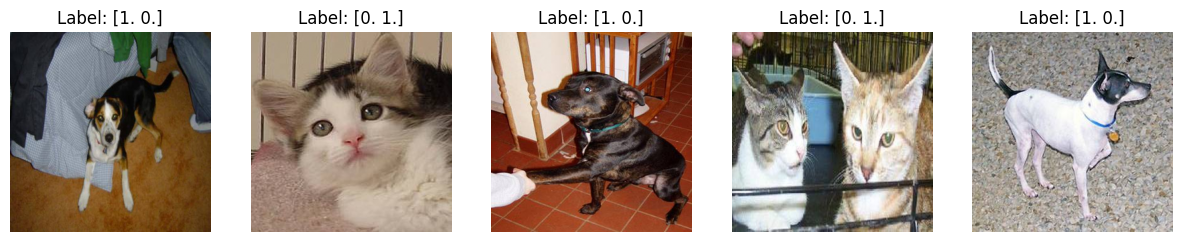

In [ ]:

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train_resized[i])
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.show()


Augmentera datan. Varför behövs dataaugmentering och hur beslutar du vilka parametrar du valt för
augmenteringen?

- Dataaugmentering behövs för att öka mängden träningsdata genom att transformera befintliga bilder. Detta bidrar till att förbättra modellens generalisering, speciellt när träningsdatan är begränsad.
- När jag läser mig till vad det står om dataaugmentering så står det att ansikten kan vara bra att rotera. Så där är en parameter, då det borde stämma in på hundar och katter också tänker jag.
- Width_shift_range och Height_shift_range: då hundar och katter kan ha olika positioner in bilden.
- Shear_range: då bilderna kan vara tagna från olika vinklar. Så en snedställning kan vara bra.
- Zoom_range: då bilder på hundar och katter kan vara olika stora i bilden.
- Horizontal_flip: Borde ju inte spela nån roll om en bild på en hund eller katt är speglad horisontellt.

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_image_generator = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False,
    height_shift_range=0.2,
    width_shift_range=0.2,
)

test_image_generator = ImageDataGenerator()  


train_val_generator = train_image_generator.flow(
    X_train_resized, y_train, batch_size=32
)

train_generator = train_image_generator.flow(
    X_train_resized, y_train, batch_size=32
)

val_generator = test_image_generator.flow(X_val_resized, y_val, batch_size=32)



Plotta några bilder efter augementering.

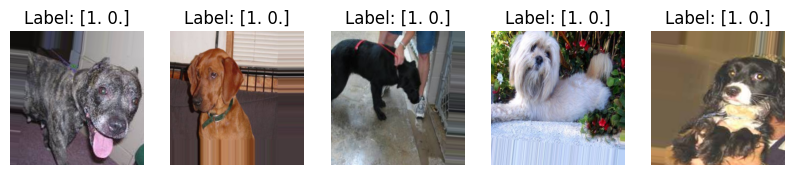

In [27]:

batch_images, batch_labels = next(train_val_generator)
num_images = 5
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(batch_images[i])
    plt.title(f"Label: {batch_labels[i]}")
    plt.axis("off")
plt.show()


------